# 0. Video started at 08:30

In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# 1. Generate data for classification problem

## 1.1 Circles data generation

In [91]:
n_samples = 10_000
RANDOM_SEED = 42
X, y = make_circles(n_samples, noise=0.01, random_state=RANDOM_SEED)

In [92]:
circles_df: pd.DataFrame = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "Label": y})
circles_df = circles_df.astype(np.float32)
circles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      10000 non-null  float32
 1   X2      10000 non-null  float32
 2   Label   10000 non-null  float32
dtypes: float32(3)
memory usage: 117.3 KB


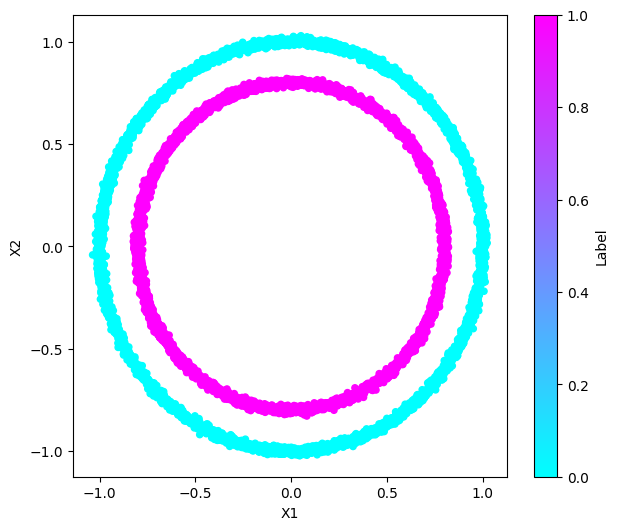

In [93]:
circles_df.plot(kind="scatter", x="X1", y="X2", c="Label", cmap="cool", colorbar=True, figsize=(7, 6))
None

## 1.2 From numpy to tensors

In [94]:
X = torch.from_numpy(circles_df[["X1", "X2"]].values)
y = torch.from_numpy(circles_df["Label"].values)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
        )

# 2. Model

## 2.1 Agnostic code

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## 2.2 Model build

### 2.2.1 Class model build

In [66]:
class CirclesModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


torch.manual_seed(RANDOM_SEED)
model_0 = CirclesModelV0().to(device=device)
model_0

CirclesModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

### 2.2.2 Alternative model build

In [28]:
torch.manual_seed(RANDOM_SEED)
model_1 = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
        ).to(device=device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### 2.2.3 Sequential model build in the class

In [37]:
class CirclesModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_linear_layers = nn.Sequential(
                nn.Linear(in_features=2, out_features=5),
                nn.Linear(in_features=5, out_features=1)
                )

    def forward(self, x):
        return self.two_linear_layers(x)


torch.manual_seed(RANDOM_SEED)
model_2 = CirclesModelV1().to(device=device)
model_2

CirclesModelV1(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

# 3 Model training

In [104]:
torch.manual_seed(RANDOM_SEED)
model = CirclesModelV0().to(device=device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

X = torch.from_numpy(circles_df[["X1", "X2"]].values)
y = torch.from_numpy(circles_df["Label"].values)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
        )

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 101


def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = correct / len(y_pred)
    return accuracy


for epoch in range(epochs):
    model.train()

    y_logits: torch.Tensor = model(X_train).squeeze()
    y_pred: torch.Tensor = torch.round(torch.sigmoid(y_logits))

    loss: torch.float32 = loss_fn(y_logits, y_train)
    acc: torch.float32 = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits: torch.Tensor = model(X_test).squeeze()
        test_predictions: torch.Tensor = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_predictions)

    if epoch % 10 == 0:
        print(
                f"Epoch: {epoch} |"
                f" Loss: {loss:.5f} |"
                f" Accuracy: {acc} % |"
                f" Test loss: {test_loss:.5f} |"
                f" Test acc: {test_acc} %",
                end="\r"
                )

### Download helper functions

In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


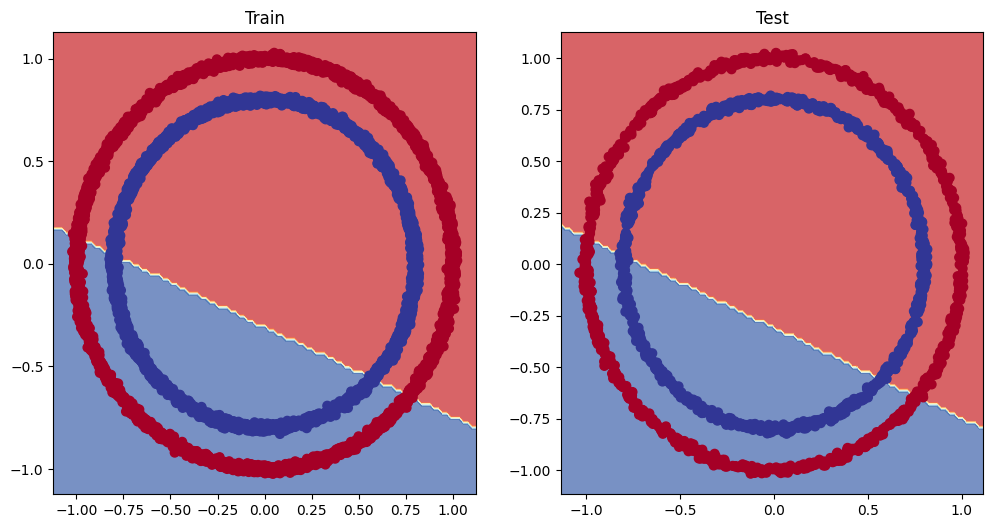

In [101]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 4. Create new more complex model 

Epoch: 0 | Loss: 0.69798 | Accuracy: 0.498375 % | Test loss: 0.69337 | Test acc: 0.5145 %
Epoch: 10 | Loss: 0.61198 | Accuracy: 0.82525 % | Test loss: 0.58129 | Test acc: 0.974 %
Epoch: 20 | Loss: 0.15327 | Accuracy: 0.99975 % | Test loss: 0.11314 | Test acc: 0.999 %
Epoch: 30 | Loss: 0.00609 | Accuracy: 1.0 % | Test loss: 0.00521 | Test acc: 1.0 %
Epoch: 40 | Loss: 0.00034 | Accuracy: 1.0 % | Test loss: 0.00031 | Test acc: 1.0 %
Epoch: 50 | Loss: 0.00007 | Accuracy: 1.0 % | Test loss: 0.00007 | Test acc: 1.0 %
Epoch: 60 | Loss: 0.00006 | Accuracy: 1.0 % | Test loss: 0.00005 | Test acc: 1.0 %
Epoch: 70 | Loss: 0.00003 | Accuracy: 1.0 % | Test loss: 0.00003 | Test acc: 1.0 %
Epoch: 80 | Loss: 0.00003 | Accuracy: 1.0 % | Test loss: 0.00003 | Test acc: 1.0 %
Epoch: 90 | Loss: 0.00003 | Accuracy: 1.0 % | Test loss: 0.00002 | Test acc: 1.0 %
Epoch: 100 | Loss: 0.00002 | Accuracy: 1.0 % | Test loss: 0.00002 | Test acc: 1.0 %


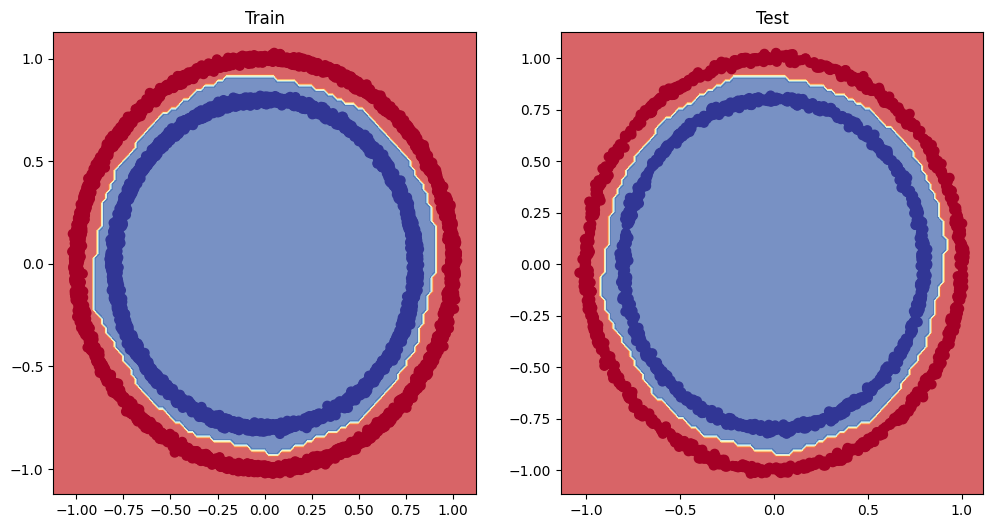

In [124]:
torch.manual_seed(RANDOM_SEED)
new_model = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1),
        )

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=new_model.parameters(), lr=0.1)
epochs = 101

X: torch.Tensor = torch.from_numpy(circles_df[["X1", "X2"]].values)
y: torch.Tensor = torch.from_numpy(circles_df["Label"].values)

X_train: torch.Tensor
X_test: torch.Tensor
y_train: torch.Tensor
y_test: torch.Tensor

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
        )

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    new_model.train()

    y_logits: torch.Tensor = new_model(X_train).squeeze()
    y_pred: torch.Tensor = torch.round(torch.sigmoid(y_logits))

    loss: torch.float32 = loss_fn(y_logits, y_train)
    acc: torch.float32 = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    new_model.eval()
    with torch.inference_mode():
        test_logits: torch.Tensor = new_model(X_test).squeeze()
        test_predictions: torch.Tensor = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_predictions)

    if epoch % 10 == 0:
        print(
                f"Epoch: {epoch} |"
                f" Loss: {loss:.5f} |"
                f" Accuracy: {acc} % |"
                f" Test loss: {test_loss:.5f} |"
                f" Test acc: {test_acc} %",
                end="\n"
                )

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(new_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(new_model, X_test, y_test)

# 5. Multiclass classification

In [10]:
import torch
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from torch import nn
from torchmetrics import Accuracy

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

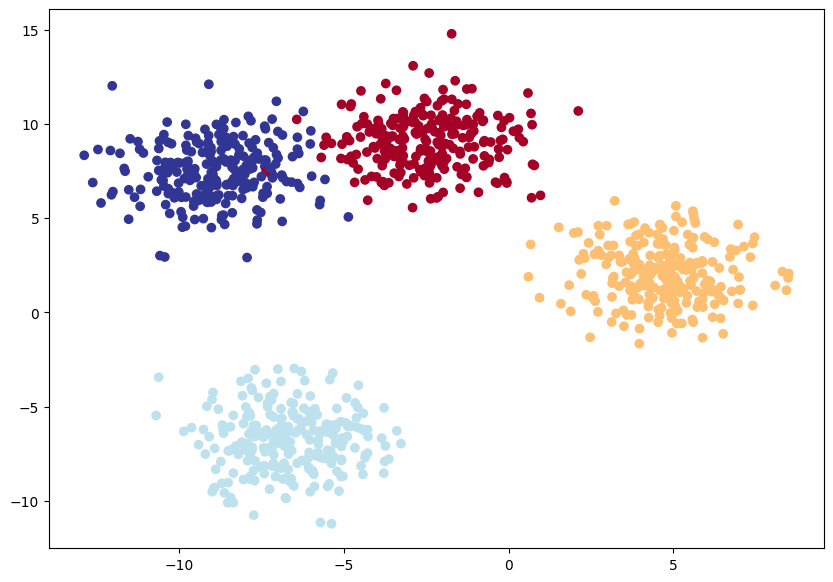

In [3]:
X_blob: np.ndarray
y_blob: np.ndarray

X_blob, y_blob = make_blobs(
        n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED
        )

f = plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

X_blob: torch.Tensor = torch.from_numpy(X_blob).type(torch.float)
y_blob: torch.Tensor = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train: torch.Tensor
X_blob_test: torch.Tensor
y_blob_train: torch.Tensor
y_blob_test: torch.Tensor

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
        X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
        )

if X_blob_train.shape[0] != y_blob_train.shape[0]: raise ValueError
if X_blob_test.shape[0] != y_blob_test.shape[0]: raise ValueError

Epoch: 0 | Loss: 1.15883 | Train accuracy: 0.40375 |Test loss: 1.14724 | Test accuracy: 0.38500
Epoch: 100 | Loss: 0.64382 | Train accuracy: 0.96875 |Test loss: 0.68117 | Test accuracy: 0.97000
Epoch: 200 | Loss: 0.41891 | Train accuracy: 0.98625 |Test loss: 0.44228 | Test accuracy: 1.00000
Epoch: 300 | Loss: 0.23740 | Train accuracy: 0.99250 |Test loss: 0.24455 | Test accuracy: 0.99500
Epoch: 400 | Loss: 0.10433 | Train accuracy: 0.99250 |Test loss: 0.10148 | Test accuracy: 0.99500
Epoch: 500 | Loss: 0.06482 | Train accuracy: 0.99250 |Test loss: 0.05914 | Test accuracy: 0.99500
Epoch: 600 | Loss: 0.05031 | Train accuracy: 0.99250 |Test loss: 0.04355 | Test accuracy: 0.99500
Epoch: 700 | Loss: 0.04289 | Train accuracy: 0.99250 |Test loss: 0.03538 | Test accuracy: 0.99500
Epoch: 800 | Loss: 0.03833 | Train accuracy: 0.99250 |Test loss: 0.03022 | Test accuracy: 0.99500
Epoch: 900 | Loss: 0.03527 | Train accuracy: 0.99250 |Test loss: 0.02690 | Test accuracy: 0.99500
Epoch: 1000 | Loss: 0.

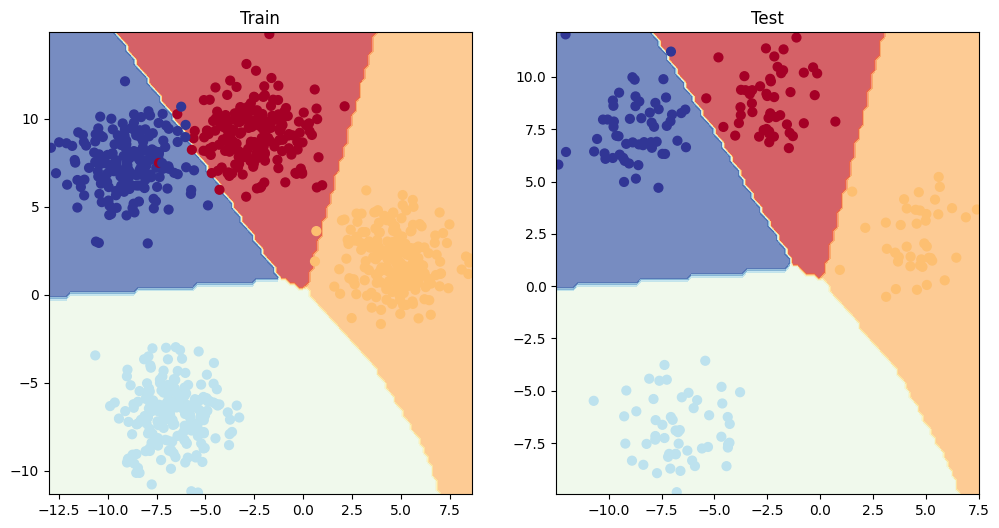

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"


class BlobModel(nn.Module):
    def __init__(self, input_features: int, output_features: int, hidden_units: int = 8):
        """
        Initializes the layers of the model 
        Args:
            input_features: number of input features to the model
            output_features: number of output features of the model (number of classes)
            hidden_units: number of hidden units between layers (default=8)
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
                nn.Linear(in_features=input_features, out_features=hidden_units),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units, out_features=hidden_units),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units, out_features=output_features)
                )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)


torch.manual_seed(RANDOM_SEED)
blob_model = BlobModel(
        input_features=NUM_FEATURES,
        output_features=NUM_CLASSES,
        ).to(device)

accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=blob_model.parameters(), lr=0.01)
epochs = 1001

for epoch in range(epochs):
    blob_model.train()

    y_logits = blob_model(X_blob_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    train_accuracy = accuracy_metric(y_blob_train, y_pred)
    loss = loss_fn(y_logits, y_blob_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()
    with torch.inference_mode():
        y_test_logits = blob_model(X_blob_test).squeeze()
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        test_accuracy = accuracy_metric(y_blob_test, y_test_pred)
        test_loss = loss_fn(y_test_logits, y_blob_test)
        
    divider = epochs // 10 
    if epoch % divider == 0:
        print(
                f"Epoch: {epoch} |"
                f" Loss: {loss:.5f} |"
                f" Train accuracy: {train_accuracy:.5f} |"
                f"Test loss: {test_loss:.5f} |"
                f" Test accuracy: {test_accuracy:.5f}"
                )

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)

# Video ended at 14:00:47